### Read Keithley 2700 Multimeter (DMM) using Python over serial communication

You may use Serial to USB converter for this job (which I did). Make sure the driver is installed properly. There are more instructions to follow, check the code comments.

USB Serial Driver Issue?

Windows 10, 64 bit machine: "Microsoft -> USB Serial Device" driver should be used.
1. Go to Device Manager, right click on the defective serial device
2. Go to "Update Driver" 
3. Browse my computer... 
4. Let me pick...
5. Remove "Show compatible hardware" check and choose Microsoft -> USB Serial Device

In [14]:
import visa #pip install pyvisa
from datetime import datetime
import time
import openpyxl # Excel processor library
import os # To open any files in file browser
import sys # Interfacing computer HID system
import readchar # pip install readchar
import numpy as np
from decimal import Decimal
import itertools
import winsound # To access windows default audio library 
import matplotlib.pyplot as plt
from matplotlib.mlab import find
%matplotlib inline

excelfile = 'CapturedData.xlsx'

rm = visa.ResourceManager()
rm.list_resources() #     < --  Shows you connected serial port devices

('ASRL1::INSTR', 'ASRL3::INSTR', 'ASRL13::INSTR')

In [10]:
keithley = rm.open_resource(rm.list_resources()[2]) # 'ASRL11::INSTR' < -- Select the appropriate one
keithley.baud_rate = 9600  #   < -- Manually set the same baud rate with the device
keithley.timeout = 1000 #   < -- Give it extra time if timeout error occurs

# '\r' when the termination character is CR (Carriage return), if it is set to LF (Line feed), 
# this can be removed and code will use '\n' by default
keithley.read_termination = '\r'  #   < -- This is very important, by default it was '\n'

In [11]:
keithley.write("*IDN?") 
keithley.read()  # Output: 'KEITHLEY INSTRUMENTS INC.,MODEL 2700,0916461,B04  /A02  '

'KEITHLEY INSTRUMENTS INC.,MODEL 2700,0916461,B04  /A02  '

In [131]:
def Excel_clear():
    i = 0
    # Excel Setup
    wb = openpyxl.load_workbook(excelfile)
    sheet = wb.active

    ######## Headings ##########
    sheet['A1'] = 'Last Updated:'
    sheet['A2'] = 'Iteration' # R1
    sheet['B2'] = 'DC Voltage' # R2
    sheet['C2'] = 'Time Stamp' # R3
    ###########################

    for row in sheet['A3:K10000']:
        for cell in row:
            cell.value = None 
    wb.save(excelfile)

In [93]:
# Better to set the reading rate: 'SLOW' in Keithley (it will average the data in the hardware for accurate measurements)
# To change the measurement mode, press local on the device, change the mode there first. This code will read whatever is on
# the screen.

def Measure():
    global Out
    keithley.write("DATA?")   
    Read = keithley.read() # Output: '+1.19479315E-04VDC,+2424.488SECS,+47668RDNG#'
    Out = Read.split(',', 3)
    return Out

In [54]:
# output = Measure()

In [132]:
# out_1 = output[0][:-3] # Measured value
# out_2 = output[1][:-4] # Time stamp
# out_3 = output[2][:-5] # Number of samples averaged

Scan: 1 , DC Voltage: 0.000119260185 V, time: 6.478452105000542
Scan: 2 , DC Voltage: 0.000118018892 V, time: 6.341866339999797
Scan: 3 , DC Voltage: 0.000118697855 V, time: 6.355884161999711
Scan: 4 , DC Voltage: 0.000118818352 V, time: 6.358868360000088
Scan: 5 , DC Voltage: 0.000118662443 V, time: 6.358872886999961
Scan: 6 , DC Voltage: 0.000118706026 V, time: 6.43183027699979
Scan: 7 , DC Voltage: 0.000118530108 V, time: 6.3608636610006215
Scan: 8 , DC Voltage: 0.000118125063 V, time: 6.365868515999864
Scan: 9 , DC Voltage: 0.000116980344 V, time: 6.340926647000742
Scan: 10 , DC Voltage: 0.000117880154 V, time: 6.341812005000065
Scan: 11 , DC Voltage: 0.000118261771 V, time: 6.353922366000006
Scan: 12 , DC Voltage: 0.000118467513 V, time: 6.3578571250000095
Scan: 13 , DC Voltage: 0.000118743381 V, time: 6.432770272000198
Scan: 14 , DC Voltage: 0.000118710013 V, time: 6.3648606019996805
Scan: 15 , DC Voltage: 0.000118628217 V, time: 6.365857347000201
Scan: 16 , DC Voltage: 0.0001185

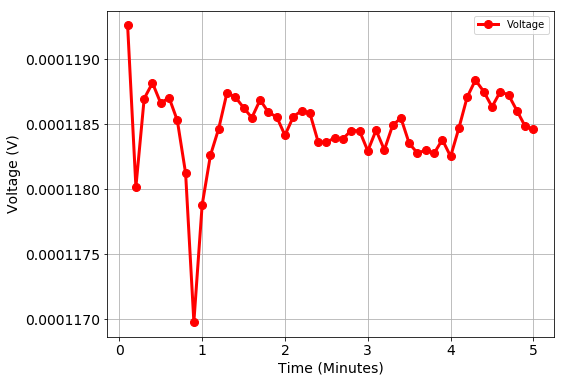

In [134]:
# Measure DC output voltage over a period of time from Keithley DMM

Excel_clear() # Clear previous measurements

time_in_min = []
DC_Volt = []
i=0
rate = 10 # data per min (must be less than 60)
duration = 5 # minutes

iterate = rate*duration

for i in range(0, iterate, 1): # Iterating i here <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    start = time.perf_counter()
    Measure()
    time_in_min.append(i)
    DC_V = float(Out[0][:-3]) # It may need modification for ACV or Ohms.
    #Current_Time = float(Out[1][:-4])
    DC_Volt.append(DC_V)
    #write to excel
    sheet.cell(row=3+i, column=1).value=i+1
    sheet.cell(row=3+i, column=2).value=DC_V
    sheet.cell(row=3+i, column=3).value=datetime.now()
    sheet['C1'] = datetime.now() # Last Updated Time Stamp
    wb.save(excelfile)
    time.sleep((60/rate))
    stop = time.perf_counter()
    runtime = stop-start
    print("Scan:", i+1, ', DC Voltage: ' + str(DC_V)+' V, time:', runtime)

winsound.PlaySound("SystemHand", winsound.SND_ALIAS)
os.startfile(excelfile)

time_min = [i + 1 for i in time_in_min]
time_frac = [i / rate for i in time_min]

plt.figure(figsize=(8,6))
line1 = plt.plot(time_frac,DC_Volt,'o-r',linewidth='3',label='Voltage',ms=8)
plt.legend()
plt.xlabel('Time (Minutes)',fontsize=14)
plt.ylabel('Voltage (V)',fontsize=14)
plt.grid()
plt.tick_params(labelsize = 14)
plt.savefig('Plot_1.png', dpi=600,bbox_inches='tight')
plt.show()